In [1]:
import os
import sys
import glob 
import random
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd
from statsmodels import robust

import librosa
import librosa.display

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import IPython.display as ipd 

import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
#initializing all the file path to a variable
AUDIO_PATH = r'C:\Users\moham\Desktop\noise_classification\esc50 and YBSS-200'
CSV_PATH =  r'C:\Users\moham\Desktop\noise_classification\csv files\esc50andYBSS200.csv'
CSV_PATH1 = r'C:\Users\moham\Desktop\noise_classification\csv files\first5keywords.csv'
CSV_PATH2 = r'C:\Users\moham\Desktop\noise_classification\csv files\first10keywords.csv'
CSV_PATH3 = r'C:\Users\moham\Desktop\noise_classification\csv files\first15keywords.csv'
CSV_PATH4 = r'C:\Users\moham\Desktop\noise_classification\csv files\YBSS_dataset.csv'
CSV_PATH5 = r'C:\Users\moham\Desktop\noise_classification\csv files\esc50new.csv'

## Part 1: Primary data analysis


In [3]:
df = pd.read_csv(CSV_PATH3)
print("shape of df: ", df.shape)
df.head()

#checking the content of the file

shape of df:  (600, 7)


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-101336-A-30.wav,1,30,door_wood_knock,False,101336,A
3,1-103995-A-30.wav,1,30,door_wood_knock,False,103995,A
4,1-103999-A-30.wav,1,30,door_wood_knock,False,103999,A


In [4]:
df=df.drop(['fold','esc10','src_file','take'], axis=1)
print("shape of df: ", df.shape)
print(df)
#filtering the table and removing the unwanted data

shape of df:  (600, 3)
              filename  target         category
0     1-100032-A-0.wav       0              dog
1    1-100038-A-14.wav      14   chirping_birds
2    1-101336-A-30.wav      30  door_wood_knock
3    1-103995-A-30.wav      30  door_wood_knock
4    1-103999-A-30.wav      30  door_wood_knock
..                 ...     ...              ...
595  5-263490-A-25.wav      25        footsteps
596  5-263491-A-25.wav      25        footsteps
597  5-263501-A-25.wav      25        footsteps
598   5-51149-A-25.wav      25        footsteps
599     5-9032-A-0.wav       0              dog

[600 rows x 3 columns]


In [5]:
#check NAS
df.isna().sum()
#checking for any file empty 

filename    0
target      0
category    0
dtype: int64

In [6]:
NUM_CLASSES = len(df['category'].unique())
len(df['category'].unique())

#printing all the unique catagories 

15

In [7]:
df['target'].value_counts()

#checking if all classes have 40 audio files

target
0     40
14    40
30    40
47    40
31    40
32    40
16    40
25    40
43    40
29    40
7     40
24    40
21    40
5     40
33    40
Name: count, dtype: int64

In [8]:
len(df) == len(df['filename'].unique())

True

In [9]:
classes = df['category'].unique()
classes

array(['dog', 'chirping_birds', 'door_wood_knock', 'airplane',
       'mouse_click', 'keyboard_typing', 'wind', 'footsteps', 'car_horn',
       'drinking_sipping', 'insects', 'coughing', 'sneezing', 'cat',
       'door_wood_creaks'], dtype=object)

## Part 2: Analysis of audio tracks

In [10]:
## an instance of each class
unique_class_df = df.drop_duplicates(subset=['target'])
unique_class_df.head()
classes = df['category'].unique()
class_dict = {i:x for x,i in enumerate(classes)}
df['target'] = df['category'].map(class_dict)
df


,filename,target,category
0,1-100032-A-0.wav,0,dog
1,1-100038-A-14.wav,1,chirping_birds
2,1-101336-A-30.wav,2,door_wood_knock
3,1-103995-A-30.wav,2,door_wood_knock
4,1-103999-A-30.wav,2,door_wood_knock
...,...,...,...
595,5-263490-A-25.wav,7,footsteps
596,5-263491-A-25.wav,7,footsteps
597,5-263501-A-25.wav,7,footsteps
598,5-51149-A-25.wav,7,footsteps


In [11]:
X = []
y = []
for data in tqdm(df.iterrows(),  desc='Progress'):
    sig , sr = librosa.load(AUDIO_PATH + "\\" + data[1][0],sr = 44100)
    #taking 3 windows from 0-2 , 2-4 , 3-5 seconds
    sig_ = sig[0 : 88200]
    if robust.mad(sig_, axis=0) > 1e-4:
        mfcc_ = librosa.feature.mfcc(y=sig_ , sr=sr,hop_length = 512, n_mfcc=40)
        X.append(mfcc_)
        y.append(data[1][1])
    sig_ = sig[88200 : 176400]
    if robust.mad(sig_, axis=0) > 1e-4:
        mfcc_ = librosa.feature.mfcc(y=sig_ , sr=sr,hop_length = 512, n_mfcc=40)
        X.append(mfcc_)
        y.append(data[1][1])
    sig_ = sig[132300 : 220500]
    if robust.mad(sig_, axis=0) > 1e-4:
        mfcc_ = librosa.feature.mfcc(y=sig_ , sr=sr,hop_length = 512, n_mfcc=40)
        X.append(mfcc_)
        y.append(data[1][1])

Progress: 0it [00:00, ?it/s]C:\Users\moham\AppData\Local\Temp\ipykernel_6292\2922706038.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sig , sr = librosa.load(AUDIO_PATH + "\\" + data[1][0],sr = 44100)
Progress: 1it [00:02,  2.15s/it]C:\Users\moham\AppData\Local\Temp\ipykernel_6292\2922706038.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sig , sr = librosa.load(AUDIO_PATH + "\\" + data[1][0],sr = 44100)
C:\Users\moham\AppData\Local\Temp\ipykernel_6292\2922706038.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

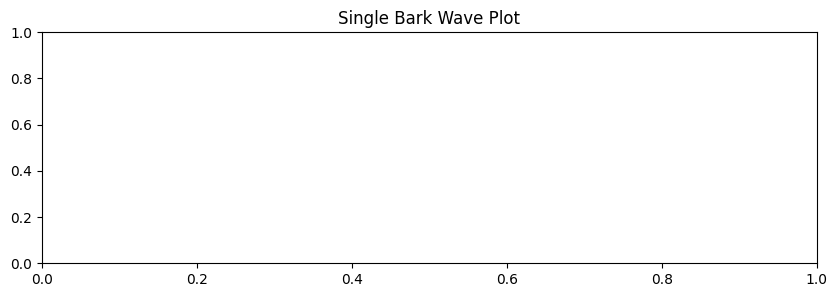

In [14]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10,3))
plt.title("Single Bark Wave Plot")
librosa.display.waveshow(y=sig_, sr=sr)
plt.show()


In [15]:
X = np.array(X) 
y = np.array(y)

In [16]:
print("X Shape is: ", X.shape)
print("y Shape is: ", y.shape)

X Shape is:  (1468, 40, 173)
y Shape is:  (1468,)


In [17]:
y = tf.keras.utils.to_categorical(y , num_classes=15)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [18]:
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

In [19]:
INPUTSHAPE = (40,173,1)

In [20]:
y.shape

(1468, 15)

In [21]:
model =  models.Sequential([
    
  layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),  
  layers.MaxPooling2D(2, padding='same'),
  layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
  layers.MaxPooling2D(2, padding='same'),
  layers.Dropout(0.3),
  layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
  layers.MaxPooling2D(2, padding='same'),
  layers.Dropout(0.3),
  layers.GlobalAveragePooling2D(),
  
  layers.Dense(512 , activation = 'relu'),
  layers.Dense(15, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'Nadam', metrics = 'acc')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 171, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 84, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 128)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 9, 42, 128)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 40, 128)        1

In [22]:
batch_size = 15
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

history = model.fit(X_train,y_train,
            validation_data=(X_test,y_test),
            epochs=25,
            callbacks = [callback],batch_size=batch_size)

Epoch 1/25
79/79 [==============================] - 5s 21ms/step - loss: 2.2625 - acc: 0.2581 - val_loss: 1.9137 - val_acc: 0.3367
Epoch 2/25
79/79 [==============================] - 1s 14ms/step - loss: 1.5608 - acc: 0.4855 - val_loss: 1.7869 - val_acc: 0.4252
Epoch 3/25
79/79 [==============================] - 1s 14ms/step - loss: 1.2984 - acc: 0.5613 - val_loss: 1.3291 - val_acc: 0.5442
Epoch 4/25
79/79 [==============================] - 1s 14ms/step - loss: 1.1153 - acc: 0.6269 - val_loss: 1.2600 - val_acc: 0.6190
Epoch 5/25
79/79 [==============================] - 1s 14ms/step - loss: 0.9514 - acc: 0.6942 - val_loss: 1.1537 - val_acc: 0.6327
Epoch 6/25
79/79 [==============================] - 1s 14ms/step - loss: 0.8152 - acc: 0.7334 - val_loss: 1.1478 - val_acc: 0.6463
Epoch 7/25
79/79 [==============================] - 1s 13ms/step - loss: 0.7120 - acc: 0.7649 - val_loss: 1.2115 - val_acc: 0.6259
Epoch 8/25
79/79 [==============================] - 1s 13ms/step - loss: 0.7025 - a

Metrics





In [23]:
pred = model.predict(X_test)

10/10 [==============================] - 1s 14ms/step


In [24]:
np.argmax(y_test,1)

array([13, 11,  8,  6,  9,  3,  4, 10, 11,  8,  6,  7, 10, 12,  7,  6,  0,
       13,  5,  5,  0,  4,  5,  0,  2,  7,  0, 10,  7,  2,  8,  4, 14,  8,
        8,  5,  0, 10,  3,  1, 14,  0,  6,  1,  2,  0,  1,  7, 11,  0,  4,
        1, 10,  1,  8, 11, 13,  2,  9,  4, 14,  1,  2, 14,  0, 11,  0, 13,
        6, 12,  5,  7,  1,  0,  5,  6,  9, 14,  7,  4, 10,  9,  1,  1, 13,
        1,  2,  3, 10,  8,  2,  7,  1,  1,  3,  0,  6,  9,  1, 10,  5,  6,
       10,  3,  1,  4,  2,  3,  0,  2,  3,  9, 12,  4,  8, 13,  0,  6, 14,
        7,  3,  1, 12,  1, 14,  4, 14,  0, 11, 11,  2, 13,  4, 13, 11, 13,
        4,  6,  5, 13,  9,  7,  0, 10, 10, 10, 13,  3,  1,  3,  1,  2, 14,
       10,  6, 12,  6, 12,  2,  5,  6,  7,  7,  0,  6,  7,  7, 14,  4,  0,
        5, 12,  1,  7,  6,  4,  3, 14, 10,  2, 13,  0, 10,  4,  3, 10,  1,
        2,  9,  8,  9,  8,  9,  5, 13, 13, 13, 14,  3,  1, 14,  2,  6, 11,
       11,  7, 12,  3,  2,  4,  0,  8,  3,  0,  1,  4,  5,  2,  1,  6,  1,
        1,  4,  5,  5, 10

In [25]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,1), np.argmax(pred,1), target_names=classes))
#number of records in the test set=support

                  precision    recall  f1-score   support

             dog       1.00      0.85      0.92        26
  chirping_birds       0.90      0.97      0.93        29
 door_wood_knock       0.79      0.88      0.83        17
        airplane       0.95      0.95      0.95        21
     mouse_click       0.81      0.65      0.72        20
 keyboard_typing       0.91      0.95      0.93        21
            wind       0.95      0.82      0.88        22
       footsteps       0.85      0.81      0.83        21
        car_horn       0.76      1.00      0.86        16
drinking_sipping       0.80      0.86      0.83        14
         insects       0.84      0.78      0.81        27
        coughing       0.79      0.79      0.79        14
        sneezing       0.86      1.00      0.92        12
             cat       0.89      0.94      0.92        18
door_wood_creaks       0.94      0.94      0.94        16

        accuracy                           0.87       294
       macro

### Сonfusion matrix

Using this matrix, you can understand in which classes


model is wrong. (i.e. which class gets confused with the other)

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test,1), np.argmax(pred,1))

<Axes: >

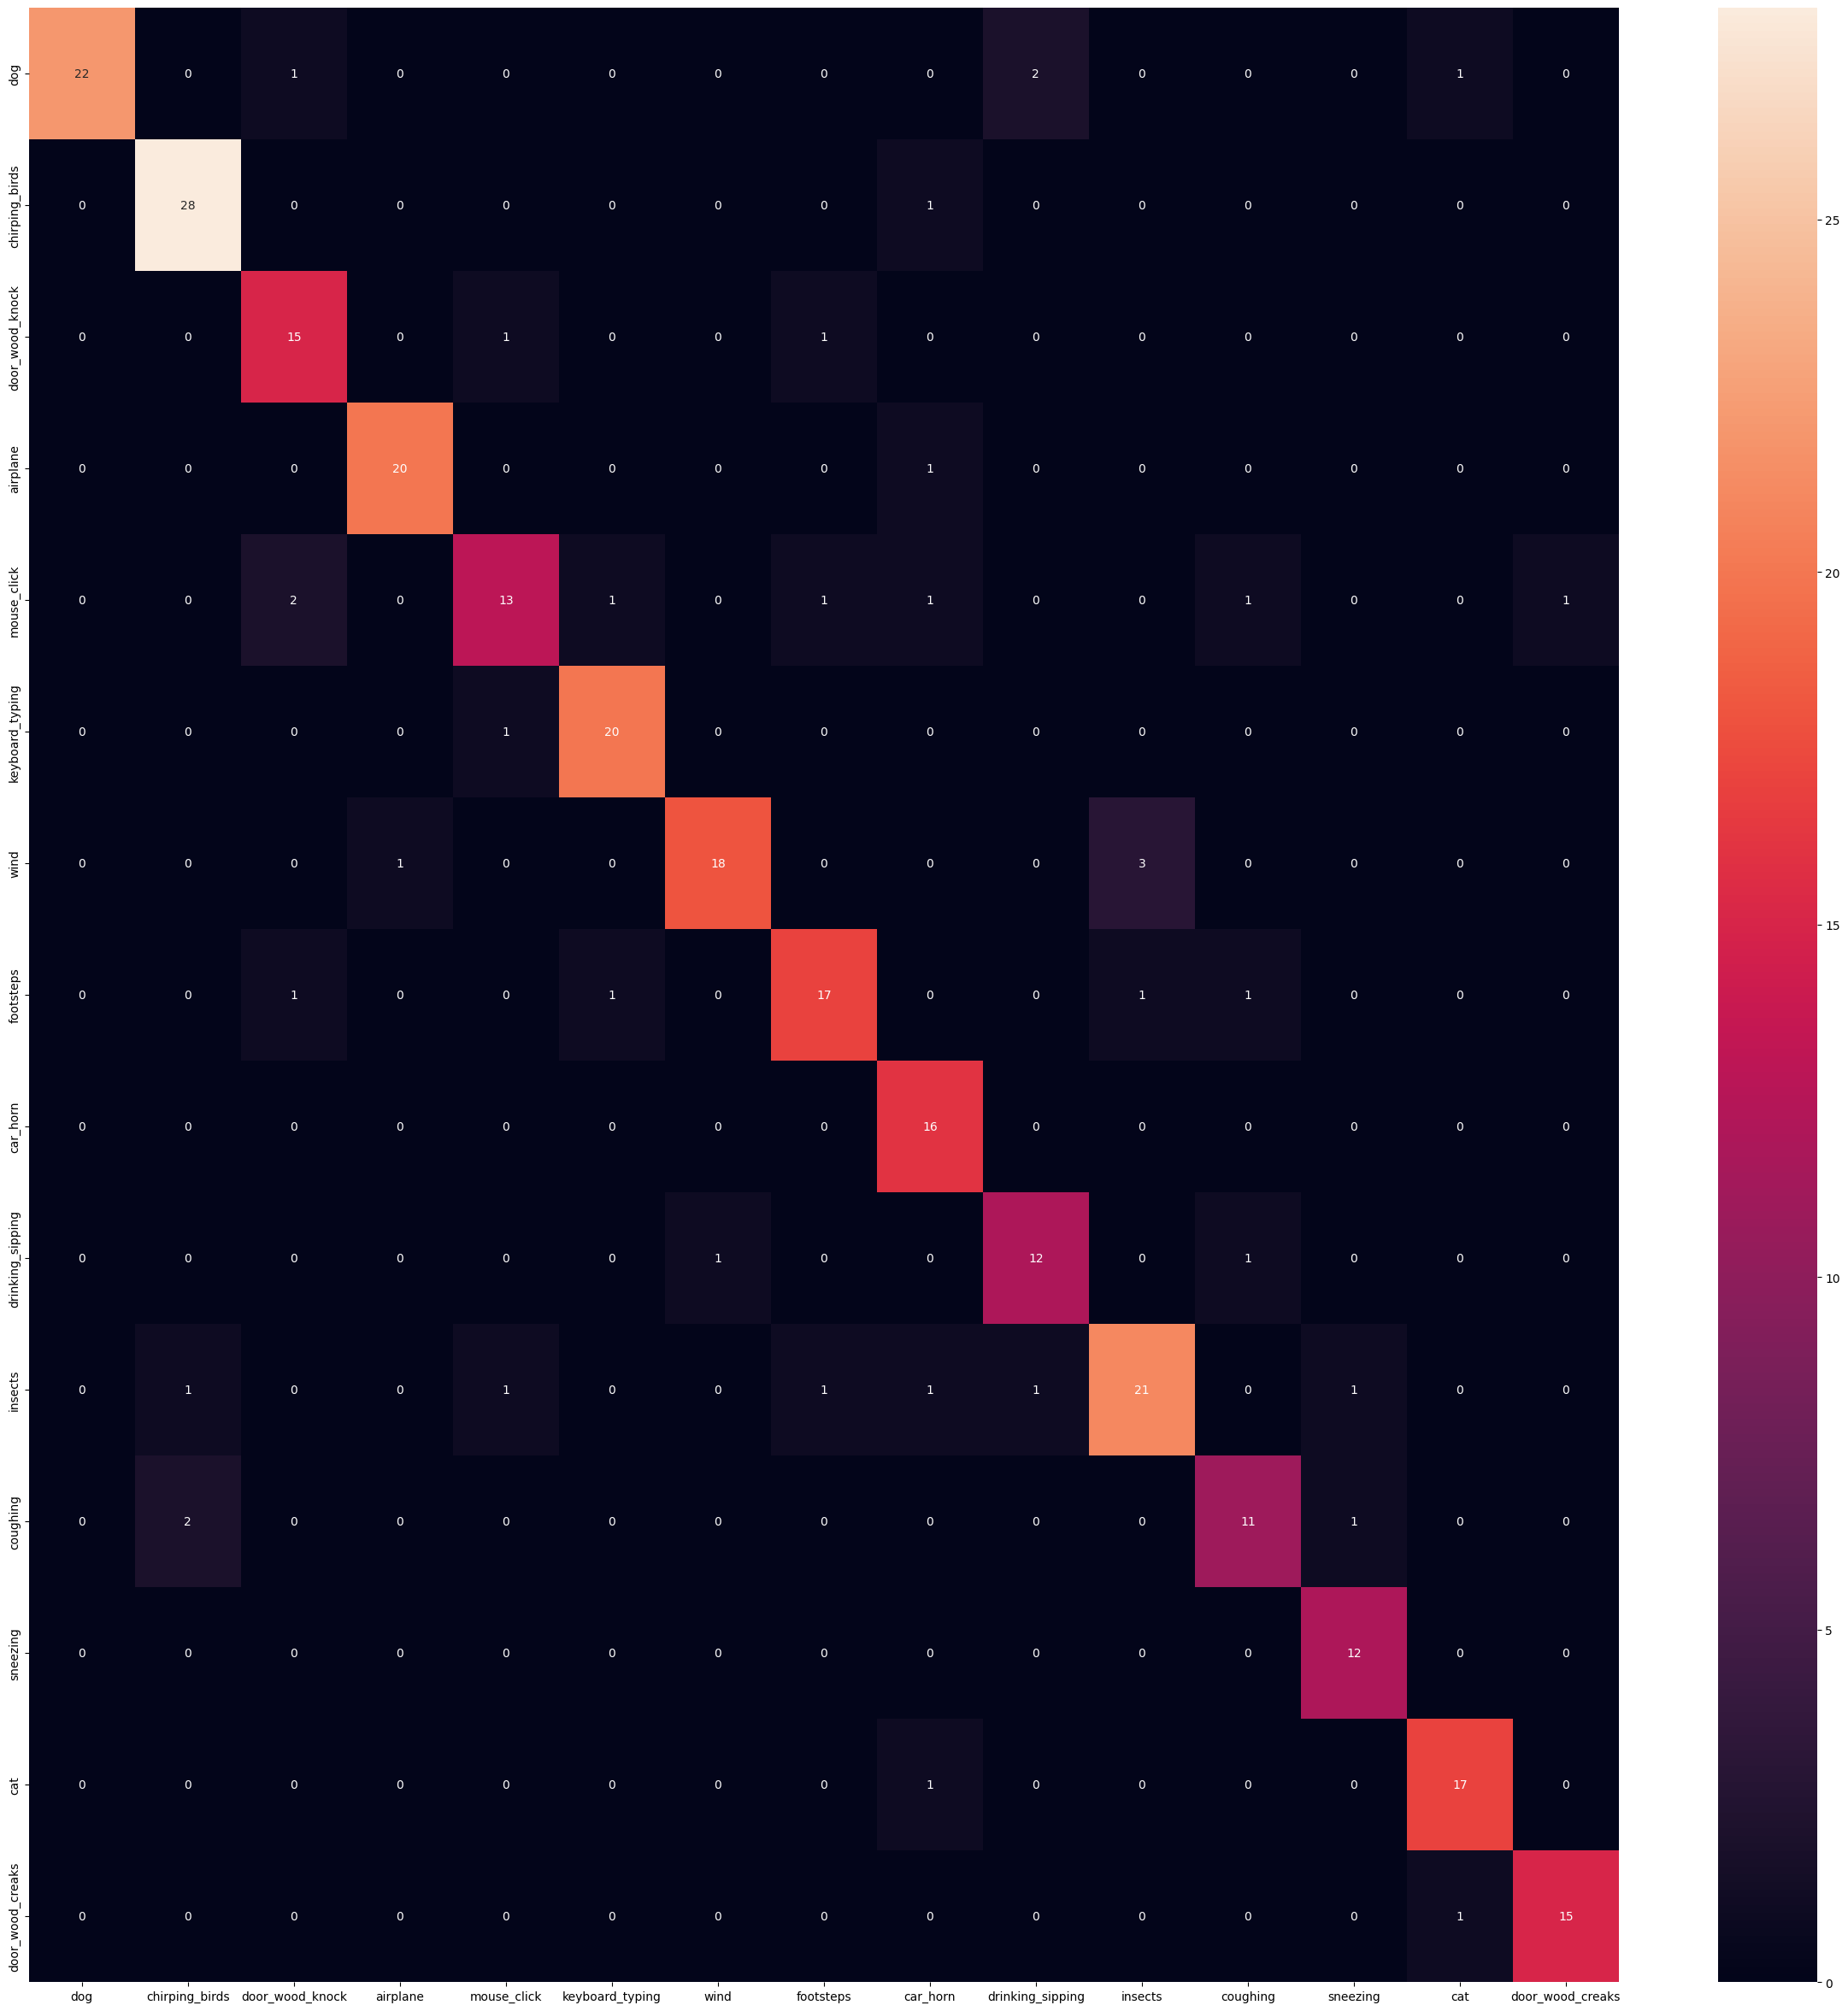

In [27]:
import seaborn as snNew
fig, ax = plt.subplots(figsize=(30,30))
snNew.heatmap(cm, annot=True, xticklabels= classes, yticklabels= classes)

In [28]:
x1 = []
y1 = []
for data in tqdm(df.iterrows(),  desc='Progress'):
        sig , sr = librosa.load(AUDIO_PATH + "\\" + data[1][0],sr = 44100)
        sig_ = sig[0 : 110250]
        mfcc_ = librosa.feature.mfcc(y=sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
        x1.append(mfcc_)
        y1.append(data[1][1])
    

Progress: 0it [00:00, ?it/s]C:\Users\moham\AppData\Local\Temp\ipykernel_6292\2418299846.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sig , sr = librosa.load(AUDIO_PATH + "\\" + data[1][0],sr = 44100)
C:\Users\moham\AppData\Local\Temp\ipykernel_6292\2418299846.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1.append(data[1][1])
Progress: 600it [00:04, 126.21it/s]


In [29]:
x1 = np.array(x1) 
y1 = np.array(y1)

In [30]:
print("X Shape is: ", x1.shape)
print("y Shape is: ", y1.shape)

X Shape is:  (600, 40, 173)
y Shape is:  (600,)


In [31]:
y1 = tf.keras.utils.to_categorical(y1 , num_classes=50)
x1 = x1.reshape(x1.shape[0], x1.shape[1], x1.shape[2], 1)

In [32]:
pred = model.predict(x1)

19/19 [==============================] - 0s 19ms/step


In [33]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y1,1), np.argmax(pred,1), target_names=classes))

                  precision    recall  f1-score   support

             dog       0.97      0.88      0.92        40
  chirping_birds       1.00      1.00      1.00        40
 door_wood_knock       0.85      1.00      0.92        40
        airplane       0.97      0.97      0.97        40
     mouse_click       0.84      0.93      0.88        40
 keyboard_typing       1.00      1.00      1.00        40
            wind       0.97      0.90      0.94        40
       footsteps       0.93      0.95      0.94        40
        car_horn       0.87      0.97      0.92        40
drinking_sipping       0.90      0.88      0.89        40
         insects       0.95      0.93      0.94        40
        coughing       1.00      0.78      0.87        40
        sneezing       0.87      0.97      0.92        40
             cat       0.97      0.95      0.96        40
door_wood_creaks       1.00      0.93      0.96        40

        accuracy                           0.94       600
       macro

In [34]:
test_path = r"C:\Users\moham\Desktop\noise_classification\concatenated audio(15 noises)"
file_names = os.listdir(test_path)

In [35]:
concat_test = []

In [36]:
for i in tqdm(file_names):
    sig , sr = librosa.load(test_path + "\\" + i,sr = 44100)
    sig_ = sig[0 : 441000]
    mfcc_ = librosa.feature.mfcc(y=sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
    concat_test.append(mfcc_)
    #y1.append(data[1][1])
    

100%|██████████| 225/225 [00:01<00:00, 125.46it/s]


In [37]:
len(sig)

441000

In [38]:
concat_test = np.array(concat_test)

In [39]:
concat_test = concat_test.reshape(concat_test.shape[0], concat_test.shape[1], concat_test.shape[2], 1)

In [40]:
concat_test.shape

(225, 40, 173, 1)

In [41]:
concat_test = np.array(concat_test)

In [42]:
prediction = model.predict(concat_test)

8/8 [==============================] - 0s 50ms/step


In [43]:
prediction_result=[]
for i in classes[np.argmax(prediction,1)]:
    prediction_result.append(i)

In [44]:
for i in classes[np.argmax(prediction,1)]:
    print(i)

airplane
car_horn
car_horn
chirping_birds
drinking_sipping
footsteps
airplane
footsteps
footsteps
footsteps
car_horn
airplane
footsteps
footsteps
airplane
car_horn
car_horn
cat
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
cat
cat
sneezing
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
dog
airplane
car_horn
cat
chirping_birds
sneezing
footsteps
sneezing
sneezing
sneezing
footsteps
chirping_birds
sneezing
footsteps
sneezing
chirping_birds
drinking_sipping
car_horn
cat
sneezing
drinking_sipping
drinking_sipping
door_wood_creaks
door_wood_knock
drinking_sipping
footsteps
insects
drinking_sipping
footsteps
drinking_sipping
drinking_sipping
footsteps
car_horn
cat
footsteps
drinking_sipping
footsteps
door_wood_creaks
door_wood_knock
drinking_sipping
footsteps
footsteps
drinking_sipping
footsteps
footsteps
footsteps
airplane
car_horn
cat
sneezing
door_wood_creaks
door_wood_creaks
door_wood_creaks
door_wood_creaks
door_wood_creaks

In [45]:
prediction_result

['airplane',
 'car_horn',
 'car_horn',
 'chirping_birds',
 'drinking_sipping',
 'footsteps',
 'airplane',
 'footsteps',
 'footsteps',
 'footsteps',
 'car_horn',
 'airplane',
 'footsteps',
 'footsteps',
 'airplane',
 'car_horn',
 'car_horn',
 'cat',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'cat',
 'cat',
 'sneezing',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'dog',
 'airplane',
 'car_horn',
 'cat',
 'chirping_birds',
 'sneezing',
 'footsteps',
 'sneezing',
 'sneezing',
 'sneezing',
 'footsteps',
 'chirping_birds',
 'sneezing',
 'footsteps',
 'sneezing',
 'chirping_birds',
 'drinking_sipping',
 'car_horn',
 'cat',
 'sneezing',
 'drinking_sipping',
 'drinking_sipping',
 'door_wood_creaks',
 'door_wood_knock',
 'drinking_sipping',
 'footsteps',
 'insects',
 'drinking_sipping',
 'footsteps',
 'drinking_sipping',
 'drinking_si

In [46]:
count = 0
for i in range(0,len(prediction_result)):
    w = file_names[i].split(".")[0]
    t = w.split("_and_")
    if prediction_result[i] in t:
        print(1)
        count = count+1
    else:
        print(0)

1
1
0
1
0
0
1
0
0
1
0
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
0
0
0
0
1
1
0
0
1
1
0
1
1
0
0
0
1
1
1
1
1
0
0
0
0
0
1
1
0
0
0
1
1
1
1
0
0
0
0
0
1
1
1
0
1
1
1
1
1
1
1
1
0
1
0
0
1
1
0
1
1
1
1
1
1
1
0
1
0
1
0
1
1
0
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
0
1
1
1
1
0
1
0
1
1
0
0
0
1
0
1
1
1
1
1
0
0
0
1
1
0
0
0
0
1
0
1
1
1
0
0
0
0
1
1
1
0
0
1
0
1
1
0
0
0
0
0
1
1
1
1
0
0
0
1
0
1
1
0
0
0
1
